# Housing prices for King County

Training a simple polynomial model on Hosing Sale data from king country [data source](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction)
As a learning exercise

In [2]:
from utils import load_data
from train import compute_cost, compute_gradient, gradient_descent
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# Data is a pandas DataFrame
data = load_data.load_data("./data/kc_house_data.csv")


# Feature Engineering
Housing prices do not tend to be linear but curve like, thus we will be engineering some polynomial features

In [3]:
labels = data['price']
data.drop('price', axis=1, inplace=True)
data.drop('date', axis=1, inplace=True)
dataSquared = data.pow(2)
dataSquared.rename(lambda c: f"{c} squared", inplace=True, axis='columns')

dataCubed = data.pow(3)
dataCubed.rename(lambda c: f"{c} cubed", inplace=True, axis='columns')

engineeredData = data.join(dataSquared).join(dataCubed)

engineeredData[0:5]

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,grade cubed,sqft_above cubed,sqft_basement cubed,yr_built cubed,yr_renovated cubed,zipcode cubed,lat cubed,long cubed,sqft_living15 cubed,sqft_lot15 cubed
0,7129300520,3,1.00,1180,5650,1.0,0,0,3,7,...,343,1643032000,0,7472058875,0,946329856735752,107247.702877,-1.827348e+06,2406104000,180362125000
1,6414100192,3,2.25,2570,7242,2.0,0,0,3,7,...,343,10218313000,64000000,7426288351,7892485271,944798095703125,108674.739386,-1.830129e+06,4826809000,445768658119
2,5631500400,2,1.00,770,10000,1.0,0,0,3,6,...,216,456533000,0,7222633237,0,941998966517952,108790.239078,-1.826272e+06,20123648000,523996494328
3,2487200875,4,3.00,1960,5000,1.0,0,0,5,7,...,343,1157625000,753571000,7587307125,0,945115872339456,107312.726660,-1.833453e+06,2515456000,125000000000
4,1954400510,3,2.00,1680,8080,1.0,0,0,3,8,...,512,4741632000,0,7845011803,0,943325698349224,107964.410613,-1.817858e+06,5832000000,422381452527


# Training Data
We have split the data into two halves, the first half will be the training data. Matrix trainingSamples contains our examples. Each row is an example and each column is a feature. Vector trainingLabels contains the labels for our training set.

In [4]:
total_rows = len(engineeredData)
trainingSetRows = total_rows // 2
trainingSamples = engineeredData[0:trainingSetRows].copy()
trainingLabels = labels[0:trainingSetRows].copy()

print(f"trainingSamples shape: {trainingSamples.shape}")
print(f"trainingLabels shape: {trainingLabels.shape}")

trainingSamples shape: (10806, 57)
trainingLabels shape: (10806,)


# Parameters
Parameter vector w and param b


In [5]:
b = 10
w = np.random.random_sample(trainingSamples.shape[1])
print(f"w shape: {w.shape}")
print(f"Initial cost: {compute_cost(trainingSamples.to_numpy(), trainingLabels.to_numpy(), w, b)}")
dj_dw, dj_db = compute_gradient(trainingSamples.to_numpy(), trainingLabels.to_numpy(), w, b)
print(f"Initial gradient dw:  {dj_dw})")
print(f"Initial gradient db: {dj_db})")

w shape: (57,)
Initial cost: 1.4457443973737018e+36
Initial gradient dw:  [-3.82554278e+25 -1.46563445e+16 -3.17593505e+16 -2.48559125e+19
  1.70755765e+21 -7.38656052e+15  8.31157190e+14  2.93086779e+15
 -1.99676684e+16 -7.69632121e+16 -1.76581691e+19 -7.19774341e+18
 -1.28472916e+19 -2.53178727e+18 -6.22984550e+20 -3.05995885e+17
  7.77018188e+17 -3.30144019e+19  3.49891846e+20  2.78799140e+35
 -3.02589020e+16 -1.08762296e+17 -7.31725539e+22  1.99202322e+27
 -8.62455515e+15  8.31157190e+14  8.62158047e+15 -5.41888747e+16
 -8.50899179e+17 -3.53469091e+22 -8.57048303e+21 -2.59123744e+22
 -5.09233896e+21 -6.09579552e+25 -1.47046042e+19 -9.48283469e+19
 -1.16517721e+23  1.74651784e+26  6.36689543e+36  1.32427658e+15
 -3.37388471e+17 -5.77518549e+25  2.67159156e+33 -8.13309058e+15
  8.31157190e+14  8.71986321e+15 -1.08527343e+17 -9.03885497e+18
  1.36732206e+25 -7.18653998e+24 -5.22416870e+25 -1.02435348e+25
 -5.96459997e+30 -7.06539721e+20  1.15729206e+22 -3.72773139e+26
  8.94615416e+31

In [6]:
# Run gradient descent
alpha = 5.0e-7
iterations = 1000
w_final, b_final, j_history = gradient_descent(trainingSamples.to_numpy(), trainingLabels.to_numpy(), w, b, compute_cost, compute_gradient, alpha, iterations)
print(f"Final cost: {compute_cost(trainingSamples.to_numpy(), trainingLabels.to_numpy(), w_final, b_final)}")


Iteration    0: Cost 285601051605308800518563809344311753316329689901678257942727359982955121132577014920425066412900352.00   


/home/ahi/PycharmProjects/HouseSalesKingCounty/train.py:24: RuntimeWarning: overflow encountered in scalar power
  cost += (f_wb - y[i]) ** 2
/home/ahi/PycharmProjects/HouseSalesKingCounty/train.py:47: RuntimeWarning: overflow encountered in multiply
  dj_dw = dj_dw + error * X[i]
/home/ahi/PycharmProjects/HouseSalesKingCounty/train.py:47: RuntimeWarning: invalid value encountered in add
  dj_dw = dj_dw + error * X[i]
/home/ahi/PycharmProjects/HouseSalesKingCounty/train.py:47: RuntimeWarning: overflow encountered in add
  dj_dw = dj_dw + error * X[i]


Iteration   10: Cost      nan   
Iteration   20: Cost      nan   
Iteration   30: Cost      nan   
Iteration   40: Cost      nan   
Iteration   50: Cost      nan   
Iteration   60: Cost      nan   
Iteration   70: Cost      nan   
Iteration   80: Cost      nan   
Iteration   90: Cost      nan   
Iteration  100: Cost      nan   
Iteration  110: Cost      nan   
Iteration  120: Cost      nan   
Iteration  130: Cost      nan   
Iteration  140: Cost      nan   
Iteration  150: Cost      nan   
Iteration  160: Cost      nan   
Iteration  170: Cost      nan   
Iteration  180: Cost      nan   
Iteration  190: Cost      nan   
Iteration  200: Cost      nan   
Iteration  210: Cost      nan   
Iteration  220: Cost      nan   
Iteration  230: Cost      nan   
Iteration  240: Cost      nan   
Iteration  250: Cost      nan   
Iteration  260: Cost      nan   
Iteration  270: Cost      nan   
Iteration  280: Cost      nan   
Iteration  290: Cost      nan   
Iteration  300: Cost      nan   
Iteration 

# Plotting cost vs iterations


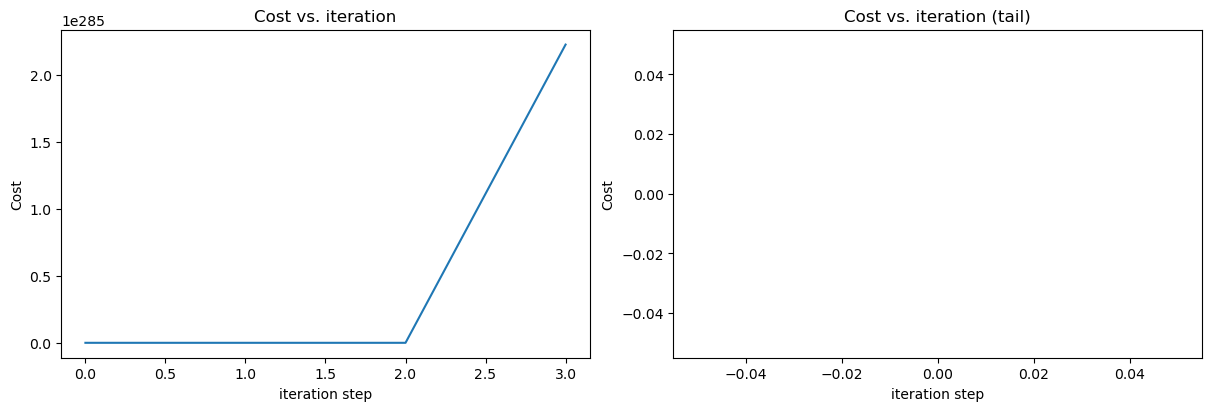

In [7]:


fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(j_history)
ax2.plot(100 + np.arange(len(j_history[100:])), j_history[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step')
plt.show()